#  Simulation: 
find timing parameters through continuous exploration

In [3]:
import numpy as np
import matplotlib.pyplot as plt  
from scipy.integrate import odeint  
from matplotlib import animation, rc   
from IPython.display import HTML
 # plot results      
import seaborn as sns
import matplotlib
import scipy as sci
import controlpy   
from timeit import default_timer as timer
import time 
import pickle
import os
import sys
 
# append function path to system
base_path = os.path.abspath(os.path.join( os.getcwd()   , os.pardir ) )
function_path = os.path.join(  base_path, 'functions') 
sys.path.append(function_path ) 
 
figs_path = os.path.join(  base_path, 'figs') 
data_path = os.path.join(  base_path, 'data')
    
# import custom functions 
from figure_settings import *    
import figure_functions as ff
import phasediagram as phd
import singlependulum as sp  

In [4]:
# Simulation parameters  
vis_limit = 0.3
visible_x =  sp.wrap2periodic( np.array([-1,1])*vis_limit + np.pi, 2*np.pi, np.pi  )  
dth_LQR_limit = np.array([ 0, 1.88]) 
time_sign = 1 
contour_col = np.array([[1,1,1,1]])*0.7 

    
# plot energy contours 
y_lim = 10
g= -10  
xc =   np.linspace( -np.pi,np.pi,1001)*1.4
yc = np.linspace(- y_lim,y_lim,1001)
Xc, Yc = np.meshgrid(xc, yc) 
Zc = - ( 1-np.cos(Xc) ) *g + 0.5* Yc**2      

lin = np.array([5,10,25,40,60 ])  

Number of time steps: 3000000
Running for :  0.0 simulation seconds
Running for :  100.0 simulation seconds
Running for :  200.0 simulation seconds
Running for :  300.0 simulation seconds
Running for :  400.0 simulation seconds
Running for :  500.0 simulation seconds
Running for :  600.0 simulation seconds
Running for :  700.0 simulation seconds
Running for :  800.0 simulation seconds
Running for :  900.0 simulation seconds
Running for :  1000.0 simulation seconds
Running for :  1100.0 simulation seconds
Running for :  1200.0 simulation seconds
Running for :  1300.0 simulation seconds
simulation done
Time to : 3000  is:  220.84 sec
number of points explored:  1300
number of trials run 1072
total nr of options in cube:  1300


(-3.141592653589793, 3.141592653589793)

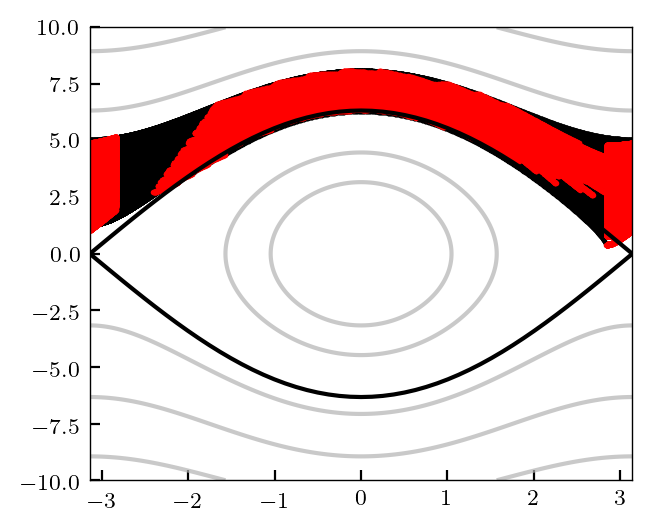

In [5]:
### # ---------controller ------------   
dt = 0.001; 
t  = np.array([0,dt]) 
tLast = 3000
tInt = np.arange(0,tLast+dt, dt) ;
n_steps = np.int(tLast/dt)
print('Number of time steps: '+ str(n_steps) ) 
 
#---------------------------------    
y = []
u = [] 
y0 = np.array([-np.pi,1.75])
y1 = y0
ytemp = y0
un = 0  
Q = 1.
R = 100. 
E_penalty = 1e6
cost_trigger = False
u_trigger = False 
 
dth_range = np.arange(0,5,0.4)  

t1_range = np.arange(0.2 ,0.7,0.05)
tau_range = np.arange(0,0.5,0.05)

J_cube = np.zeros( (len(t1_range), len(tau_range), len(dth_range)) )
n_IC0 = np.sum(   dth_range < 1.01 )
J_cube[:,:,:n_IC0 ] = 1e9
J_cube[0,0,:n_IC0 ] = 1
 
t1 = t1_range[0]
tau = tau_range[1]
t_start = time.time() 
n_trials = 0 
LQR_trigger= False
bool_show_intermediate_output = False
#------------------------------------Simulate  -------------------------------

for j in range(n_steps): 
    y.append(y0)  
    u.append(un)      
    un = 0 
    
    # is the u_thing triggered?   % compare 1 timestep before with current, did it cross the threshold
    # leaving the LQR region
    if ( y0[0] > (-np.pi + 0.3)) & (ytemp[0] < (-np.pi + 0.3)) :
        
        
#         print('end energy ', sp.compute_dE(y0[0],y0[1]), tau ) 
        u_trigger =  True    
        j_u = 0
        cost_trigger = True
        j_c  = 0  
         
        dth = y0[1] 
        id_dth = np.where( dth> dth_range  )[0][-1]   
        J_mat = J_cube[:, :,id_dth]  

        # find zeros at this particular starting level. If full of data, then move to differnet level
        if np.count_nonzero(J_mat==0) > 0:
            
            # this fixes tau and continues search in t
            idx= np.where(J_mat==0)[0][0]
            idy = np.where(J_mat==0)[1][0] 
            # select next nonzero entry
            t1 = t1_range[idx] 
            tau = tau_range[idy] 
            
#             # this fixes t  and continues search in tau
#             idx= np.where(J_mat.transpose()==0)[0][0]
#             idy = np.where(J_mat.transpose()==0)[1][0] 
#             t1 = t1_range[idy] 
#             tau = tau_range[idx] 
            
             
        elif np.count_nonzero( J_cube[:, :,:id_dth] ==0) == 0:
            tau = tau_range[0]
            t1 = t1_range[0]
        # bleed energy to move to different lower level
        else:  
            tau = tau_range[1]
            t1 = t1_range[0]
#             tau = tau_range[1]  # do nothing and get boosted again 
    
    
    
    
    # Trgger if LQR region is entered 
    if ((sp.wrap2periodic(y1[0],2*np.pi ,  np.pi  )  > (np.pi-0.3)) &   
         (sp.wrap2periodic(ytemp[0],2*np.pi ,  np.pi  )  < (np.pi-0.3)) ):
#         print('LQR region entered') 
        u_trigger = False 
        LQR_trigger= True
        LQR_y0 = y0
        
        bool_dthmax = LQR_y0[1] < dth_range[-1]
        dth_ix = np.where( LQR_y0[1]> dth_range  )[0][-1] 
        bool_levels_explored = (np.count_nonzero( J_cube[:,:,:(dth_ix+1)] == 0 )==0) #  | (dth_ix == 0) 
        
        bool_should_boost =  bool_dthmax & bool_levels_explored 
#         print(dth_ix,bool_should_boost)
        
    # in LQR region, boost if conditions require it 
    if LQR_trigger: 
        if  bool_should_boost:
            un = 3  

        # if leaving LQR region, remove trigger 
        if ((sp.wrap2periodic(y1[0],2*np.pi ,  np.pi  )  > (np.pi+0.3)) &   
         (sp.wrap2periodic(ytemp[0],2*np.pi ,  np.pi  )  < (np.pi+0.3)) ):
            LQR_trigger = False 
        
        
    if np.sum( J_cube == 0 )== 0:
        print('simulation done') 
        break 
        
         

        
    # finish up one iteration 
    if cost_trigger: 
        j_c = j_c + 1
        
        # end of trigger, evaluate cost of control policy -----------------------------
        if ( y0[0] > ( np.pi -  0.3)) & (ytemp[0] < ( np.pi - 0.3)) :
            
            y_use = np.array( y[-j_c:] ) 
            u_use = np.array( u[-j_c:] ) 
            
            dth = y[-j_c][1] 
             
            E = sp.compute_dE( y_use[:,0], y_use[:,1] )
            U = np.array(u) 

            e_error = np.abs(E[-1])  
            LQR_conv_bool = (y1[0] > dth_LQR_limit[0] ) &   (y1[1] < dth_LQR_limit[1] )

            if  LQR_conv_bool:
                e_error = 0  
            J = np.sum( E**2*Q+ u_use**2*R)  + E_penalty *e_error 
      
            cost_trigger = False 
            j_c  = 0 
            
            # store control function 
            id_t1 = np.where( t1 ==  t1_range  )[0][0]
            id_tau = np.where( tau ==  tau_range  )[0][0]
            id_dth = np.where( dth > dth_range  )[0][-1] 

            J_cube[id_t1, id_tau,id_dth] = J 
            
            if bool_show_intermediate_output:
#                 print('J_stored : t1:', t1, ', tau:',tau, ', dth:',dth, ' J:', J)  
                
                print("dth:{}, t1:{}, tau:{}, J:{} ".format( round(dth,2), round(t1,2), round(tau,2), round(J) ) ) 
            n_trials = n_trials + 1 
             
                
            if (y0[1]< 1.6 ):
                J = J 
#                 J_cube[:,id_tau:,id_dth] = J + 1e9
                
                # less conservatiev
                J_cube[id_t1,id_tau,id_dth] = J 
                J_cube[:,(id_tau+1):,id_dth] = J  + 1e9
                 
        
    ytemp = y0  # store a 1 delay timestep
    
    
    
    # once triggered, enact out a protocol 
    if u_trigger: 
        j_u = j_u + 1
        t_sim = tInt[j_u]
        if  (t_sim> t1) & (t_sim< (t1+ np.abs(tau) )) :
            un = -3
        elif  (t_sim > (t1+ np.abs(tau) )) :
            u_trigger = False
        else: 
            un = 0  
            
    # simulate data 
    y1 = odeint(  sp.pendulum_ode, y0,  t, args=(un ,time_sign,)  )[1]     # ode solver 
    y1[0] = sp.wrap2periodic(y1[0]) 
    y0 = y1    

    if  np.mod(j,100000) == 0:
        print( 'Running for : ', np.round(j/1000), 'simulation seconds' )
     
print('Time to :', tLast, ' is: ', round(time.time()-t_start,2) , 'sec')
print('number of points explored: ' , np.count_nonzero(J_cube) )
print('number of trials run', n_trials) 
print('total nr of options in cube: ' , len( J_cube.ravel() )  )

#------------------------------------Convert data to arrays -------------------------------
y_data= np.array(y) 
u_data = np.array(u) 
u_bool  = (np.abs( u) > 0.1)

#------------------------------------Plotting -------------------------------
fig,ax1 = plt.subplots(1,1,figsize = (3.5,3), dpi = 200)
  
# plot contours
CS = ax1.contour(Xc, Yc, Zc ,colors = contour_col  , levels = lin, zorder = 1)    

# homoclinic plot 
phd.homoclinic_plot(ax_plot=ax1,x_low = -2*np.pi, x_high = 2*np.pi, col = np.array([1,1,1])*0)
 
# plot data
ax1.scatter( y_data[:,0], y_data[:,1] ,0.1, 'k' ) 
ax1.scatter( y_data[u_bool,0], y_data[u_bool,1] ,1 ,'r') 

#-initialize axis limits 
ax1.set_xlim( np.array([-1,1])*np.pi   ) 
# ax1.set_ylim( np.array([-1,1])*10 )    



In [6]:
u_list = []
 
for j in range(np.shape(J_cube)[2]): 

    J_mat = J_cube[:,:,j]
     
    J_mat[J_mat == 0 ] = 1e8
    ix_t1,ix_tau= np.unravel_index(J_mat.argmin(), J_mat.shape)
    t1 = t1_range[ix_t1]
    tau = tau_range[ix_tau]
    
    u_list.append([dth_range[j], t1,tau])  
    
u_list

[[0.0, 0.2, 0.0],
 [0.4, 0.2, 0.0],
 [0.8, 0.2, 0.0],
 [1.2000000000000002, 0.6499999999999999, 0.0],
 [1.6, 0.49999999999999994, 0.0],
 [2.0, 0.39999999999999997, 0.05],
 [2.4000000000000004, 0.39999999999999997, 0.1],
 [2.8000000000000003, 0.39999999999999997, 0.15000000000000002],
 [3.2, 0.3, 0.2],
 [3.6, 0.2, 0.30000000000000004],
 [4.0, 0.3, 0.35000000000000003],
 [4.4, 0.2, 0.45],
 [4.800000000000001, 0.2, 0.45]]

(-0.2, 1)

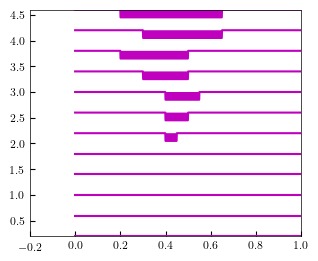

In [7]:
fig_dim = ( 3.5,3)  
U_mat = np.array(u_list)
u_col = 'm'

t_end = 1.2

fig, ax2 = plt.subplots(1,1,figsize=fig_dim ,dpi=100)  

for j in range(len(U_mat)-1):
    t1= U_mat[j,1]
    tau = U_mat[j,2] 
    y_mid = np.mean( U_mat[j:(j+2),0] )
     
    tInt = np.arange(0,t_end,dt) 
    u_l = np.zeros( (len(tInt) ))
    bool_on = (tInt>t1) & (tInt < (t1+tau) )
    u_l[bool_on]= -0.15
    ax2.plot( tInt, u_l + y_mid,color=u_col )
    
    ax2.fill_between( tInt,  u_l +y_mid, y_mid ,facecolor =u_col  ) 
    
ax2.set_xlim([-0.2, 1])       

# save data 

In [8]:
data_list = [y_data,u_data  ] 

filename_learning = os.path.join( data_path,  'continuouslearning_data.pickle')

with open( filename_learning, 'wb') as handle:
    pickle.dump(data_list, handle  )

In [9]:
 
filename_grouping = os.path.join( data_path,  'feedforward_grouping_learned')

np.save(filename_grouping, np.array(u_list) )